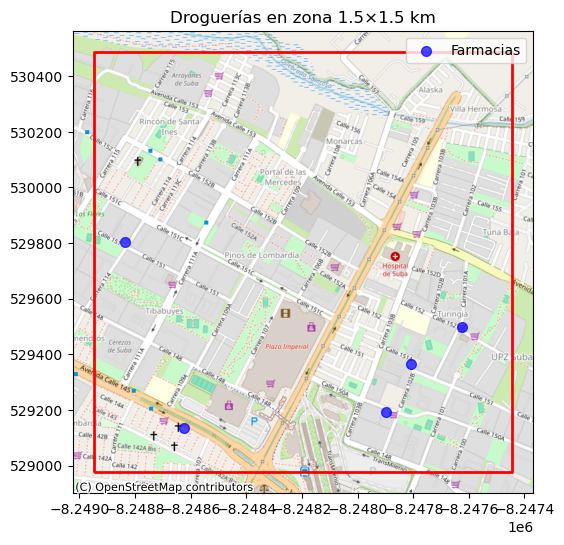

Mapa guardado en mapa_farmacias.png


In [5]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box
import requests

def get_pharmacies(center_lat, center_lon, size_km=1):
    # Calcular bounding box
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg

    # Overpass API query
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json];
    (
      node["amenity"="pharmacy"]({lat_min},{lon_min},{lat_max},{lon_max});
    );
    out center;
    """
    response = requests.get(overpass_url, params={'data': query})
    data = response.json()

    # Extraer coordenadas
    coords = [(el["lon"], el["lat"]) for el in data["elements"] if el["type"] == "node"]

    # Crear GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(
        [c[0] for c in coords], 
        [c[1] for c in coords]
    ), crs="EPSG:4326")

    return gdf

def plot_area_with_pharmacies(center_lat, center_lon, size_km=1, zoom=16, filename="mapa_farmacias.png"):
    # Bounding box para el área
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg
    bbox = box(lon_min, lat_min, lon_max, lat_max)

    gdf_area = gpd.GeoDataFrame({"geometry": [bbox]}, crs="EPSG:4326")
    gdf_area_web = gdf_area.to_crs(epsg=3857)

    # Obtener farmacias
    gdf_pharm = get_pharmacies(center_lat, center_lon, size_km)
    gdf_pharm_web = gdf_pharm.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf_area_web.boundary.plot(ax=ax, edgecolor="red", linewidth=2)
    if not gdf_pharm_web.empty:
        gdf_pharm_web.plot(ax=ax, color="blue", markersize=50, alpha=0.7, label="Farmacias")

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    plt.legend()
    plt.title(f"Droguerías en zona {size_km}×{size_km} km")
    plt.show()

    # Guardar a archivo
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Mapa guardado en {filename}")


# Ejemplo: 1 km alrededor de Bogotá centro
plot_area_with_pharmacies(center_lat=4.7532, center_lon=-74.0948, size_km=1.5)


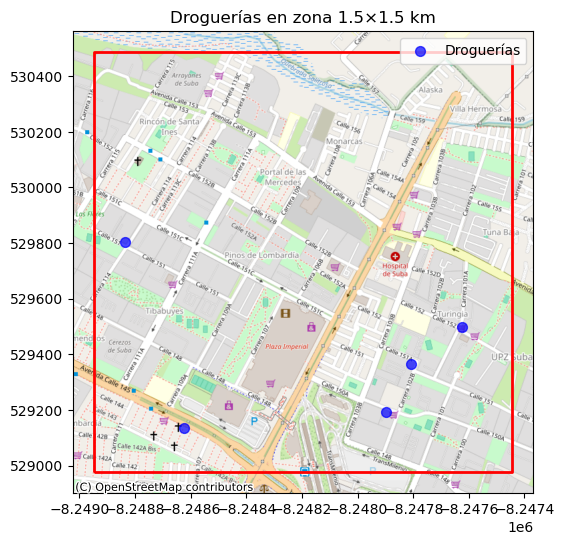

Mapa de Droguerías guardado en droguerias.png


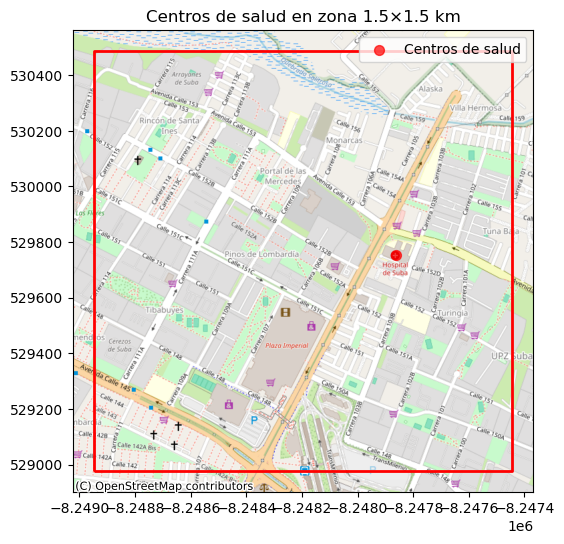

Mapa de Centros de salud guardado en salud.png


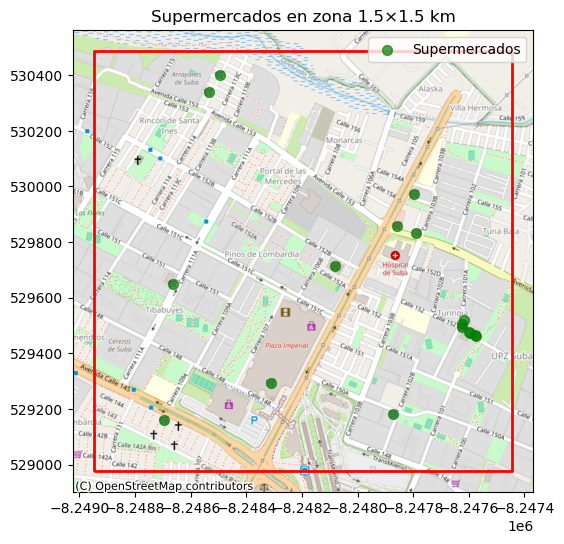

Mapa de Supermercados guardado en supermercados.png


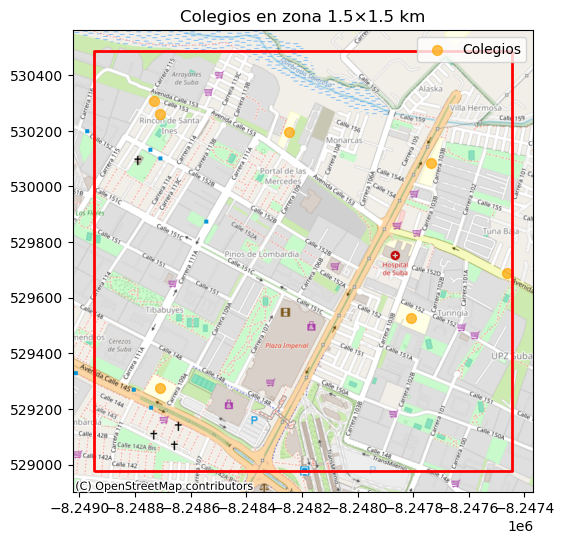

Mapa de Colegios guardado en colegios.png


In [7]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box
import requests

def get_pois(center_lat, center_lon, size_km, query_filter):
    # Calcular bounding box
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg

    # Overpass API query
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json];
    (
      node{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      way{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      relation{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
    );
    out center;
    """
    response = requests.get(overpass_url, params={'data': query})
    data = response.json()

    # Extraer coordenadas
    coords = []
    for el in data["elements"]:
        if "lon" in el and "lat" in el:
            coords.append((el["lon"], el["lat"]))
        elif "center" in el:
            coords.append((el["center"]["lon"], el["center"]["lat"]))

    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            [c[0] for c in coords],
            [c[1] for c in coords]
        ),
        crs="EPSG:4326"
    )

    return gdf

def plot_category(center_lat, center_lon, size_km, zoom, category_name, query_filter, color, filename):
    # Bounding box para el área
    delta_deg = (size_km / 111.0) / 2
    lat_min = center_lat - delta_deg
    lat_max = center_lat + delta_deg
    lon_min = center_lon - delta_deg
    lon_max = center_lon + delta_deg
    bbox = box(lon_min, lat_min, lon_max, lat_max)

    gdf_area = gpd.GeoDataFrame({"geometry": [bbox]}, crs="EPSG:4326")
    gdf_area_web = gdf_area.to_crs(epsg=3857)

    # Obtener POIs
    gdf_pois = get_pois(center_lat, center_lon, size_km, query_filter)
    gdf_pois_web = gdf_pois.to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))
    gdf_area_web.boundary.plot(ax=ax, edgecolor="red", linewidth=2)
    if not gdf_pois_web.empty:
        gdf_pois_web.plot(ax=ax, color=color, markersize=50, alpha=0.7, label=category_name)

    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    plt.legend()
    plt.title(f"{category_name} en zona {size_km}×{size_km} km")
    plt.show()

    # Guardar
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Mapa de {category_name} guardado en {filename}")


# Coordenadas de ejemplo (Bogotá centro)
lat, lon = 4.7532, -74.0948
size_km = 1.5
zoom = 16

# Droguerías
plot_category(lat, lon, size_km, zoom, "Droguerías", '["amenity"="pharmacy"]', "blue", "droguerias.png")

# Centros de salud
plot_category(lat, lon, size_km, zoom, "Centros de salud", '["amenity"="hospital"]', "red", "salud.png")

# Supermercados
plot_category(lat, lon, size_km, zoom, "Supermercados", '["shop"="supermarket"]', "green", "supermercados.png")

# Colegios
plot_category(lat, lon, size_km, zoom, "Colegios", '["amenity"="school"]', "orange", "colegios.png")


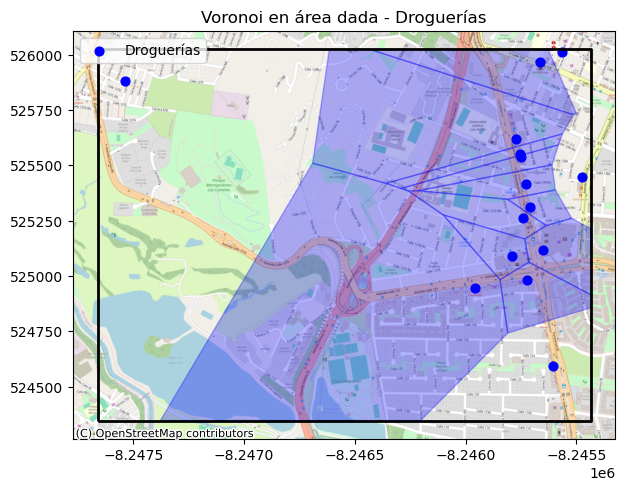

Mapa Voronoi de Droguerías guardado en voronoi_droguerias.png
No se encontraron Centros de salud en el área.


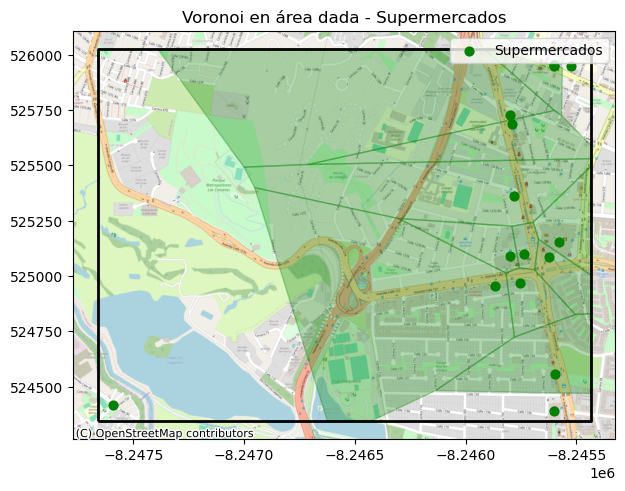

Mapa Voronoi de Supermercados guardado en voronoi_supermercados.png


In [19]:
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import box, Polygon
from shapely.ops import unary_union
from scipy.spatial import Voronoi
import numpy as np
import requests

def get_pois_in_bbox(lat_min, lon_min, lat_max, lon_max, query_filter):
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
    [out:json];
    (
      node{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      way{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
      relation{query_filter}({lat_min},{lon_min},{lat_max},{lon_max});
    );
    out center;
    """
    response = requests.get(overpass_url, params={'data': query})
    data = response.json()

    coords = []
    for el in data["elements"]:
        if "lon" in el and "lat" in el:
            coords.append((el["lon"], el["lat"]))
        elif "center" in el:
            coords.append((el["center"]["lon"], el["center"]["lat"]))

    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(
            [c[0] for c in coords],
            [c[1] for c in coords]
        ),
        crs="EPSG:4326"
    )
    return gdf

def voronoi_clipped(points, bbox):
    vor = Voronoi(points)
    polygons = []
    for region in vor.regions:
        if not region or -1 in region:
            continue
        polygon = Polygon([vor.vertices[i] for i in region])
        if polygon.is_valid:
            polygons.append(polygon)
    gdf_voronoi = gpd.GeoDataFrame({"geometry": polygons}, crs="EPSG:3857")
    # Recortar con bounding box
    return gpd.overlay(gdf_voronoi, bbox, how="intersection")

def plot_voronoi_category(bbox_coords, category_name, query_filter, color, filename, zoom=17):
    lat_min, lon_min, lat_max, lon_max = bbox_coords
    bbox_poly = box(lon_min, lat_min, lon_max, lat_max)
    gdf_bbox = gpd.GeoDataFrame({"geometry": [bbox_poly]}, crs="EPSG:4326")
    gdf_bbox_web = gdf_bbox.to_crs(epsg=3857)

    # Obtener POIs
    gdf_pois = get_pois_in_bbox(lat_min, lon_min, lat_max, lon_max, query_filter)
    if gdf_pois.empty:
        print(f"No se encontraron {category_name} en el área.")
        return
    gdf_pois_web = gdf_pois.to_crs(epsg=3857)

    # Voronoi
    points = np.array([(geom.x, geom.y) for geom in gdf_pois_web.geometry])
    gdf_voronoi = voronoi_clipped(points, gdf_bbox_web)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 7))
    gdf_bbox_web.boundary.plot(ax=ax, color="black", linewidth=2)
    gdf_voronoi.plot(ax=ax, alpha=0.3, edgecolor=color, facecolor=color)
    gdf_pois_web.plot(ax=ax, color=color, markersize=40, label=category_name)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    plt.legend()
    plt.title(f"Voronoi en área dada - {category_name}")
    plt.show()

    fig.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Mapa Voronoi de {category_name} guardado en {filename}")


# --- Aquí defines tu área manualmente ---
# Coordenadas (ejemplo, ajusta con tu bounding box real)
lat_min, lon_min = 4.705, -74.09
lat_max, lon_max = 4.72, -74.07
bbox_coords = (lat_min, lon_min, lat_max, lon_max)

# Droguerías
plot_voronoi_category(bbox_coords, "Droguerías", '["amenity"="pharmacy"]', "blue", "voronoi_droguerias.png")

# Centros de salud
plot_voronoi_category(bbox_coords, "Centros de salud", '["amenity"="hospital"]', "red", "voronoi_salud.png")

# Supermercados
plot_voronoi_category(bbox_coords, "Supermercados", '["shop"="supermarket"]', "green", "voronoi_supermercados.png")
